### TASK LIST:

###### --------------------------------------------------------------


###### --- Still Need to Do ---
###### 1. Subtract Sky background from Sid Data
###### 2. Find Filter Zero Point for R Filter
###### 3. Convert to Magnitudes
###### 4. look at obs astro photometry exercises for sky background 
###### 5. Airmass correction 
###### 6. interstellar extinction correction
###### 7. Dust extinction correction
###### 8. reddening correction
###### 9. Find stars of similar(larger) mag within a close radius of wasp. 
###### To find flat field of the image find one of those stars and it should have a constant count. 
###### Find other stars within a confidence interval(.99) of that star, expanding the radius around wasp until you get a chosen minimum number of stars(maybe 50)


###### --------------------------------------------------------------


###### DIP LIKELY CAUSED BY CLOUDS

###### OUR IMPACT PARAMETER IS 0.8 (QUITE HIGH ON THE STAR) SO WE EXPECT LONGER EGRES AND IGRES AND LESS TIME IN A FULL DIP, 
###### WHICH MEANS THAT IF THE CLOUDS IMPACT OUR IGRES OR EGRES WE MIGHT HAVE A PROBLEM


###### -------------------------------------------------------------


###### Solution to dip in the theory:
###### 1. Find affected images
###### 2. Calculate an attenuation factor for those images based on comparison stars
###### 3. Apply attenuation factor to WASP-135b data points in those images
###### 4. Re-plot light curve and see if dip is resolved


###### -------------------------------------------------------------

### <div style="height:50px"></div>

### IMPORTING FUNCTIONS:

In [1]:
#Imports

from astropy.io import fits
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from astropy.stats import sigma_clipped_stats
from photutils.detection import DAOStarFinder
from photutils.aperture import CircularAperture, ApertureStats
import os

### <div style="height:50px"></div>

### FITS FILE IMAGE AND EXTRACTION:

#### • Import and store the FITS file information in a list

In [ ]:
fits_files = []
for i in range(1, 150, 1):
    fits_files.append(f'raw_pirate_data/PIRATE_{i}_OSL_ROE_EXO1_WASP135b_Filter_R.fits')
print(fits_files)

fits_data = []
for fits_file in fits_files:
    hdul = fits.open(fits_file)         # Open the FITS file
    image_data = hdul[0].data           # Get the image data
    fits_data.append(image_data)        # Store the image data
    hdul.close()                        # Close the FITS file
print(fits_data)

#### • Produces an image of the FITS file and prints off the Header information:

/Users/connor/Documents/University/Fourth_Year/Telescope_Group_Project/Light_Curve_Analysis
True
['PIRATE_150_OSL_ROE_EXO1_WASP135b_Filter_R.fits', 'PIRATE_117_OSL_ROE_EXO1_WASP135b_Filter_R.fits', 'PIRATE_25_OSL_ROE_EXO1_WASP135b_Filter_R.fits', 'PIRATE_62_OSL_ROE_EXO1_WASP135b_Filter_R.fits', 'PIRATE_120_OSL_ROE_EXO1_WASP135b_Filter_R.fits', 'PIRATE_167_OSL_ROE_EXO1_WASP135b_Filter_R.fits', 'PIRATE_55_OSL_ROE_EXO1_WASP135b_Filter_R.fits', 'PIRATE_12_OSL_ROE_EXO1_WASP135b_Filter_R.fits', 'PIRATE_104_OSL_ROE_EXO1_WASP135b_Filter_R.fits', 'PIRATE_143_OSL_ROE_EXO1_WASP135b_Filter_R.fits', 'PIRATE_71_OSL_ROE_EXO1_WASP135b_Filter_R.fits', 'PIRATE_36_OSL_ROE_EXO1_WASP135b_Filter_R.fits', 'PIRATE_133_OSL_ROE_EXO1_WASP135b_Filter_R.fits', 'PIRATE_46_OSL_ROE_EXO1_WASP135b_Filter_R.fits', 'PIRATE_39_OSL_ROE_EXO1_WASP135b_Filter_R.fits', 'PIRATE_80_OSL_ROE_EXO1_WASP135b_Filter_R.fits', 'PIRATE_49_OSL_ROE_EXO1_WASP135b_Filter_R.fits', 'PIRATE_118_OSL_ROE_EXO1_WASP135b_Filter_R.fits', 'PIRATE_93_O

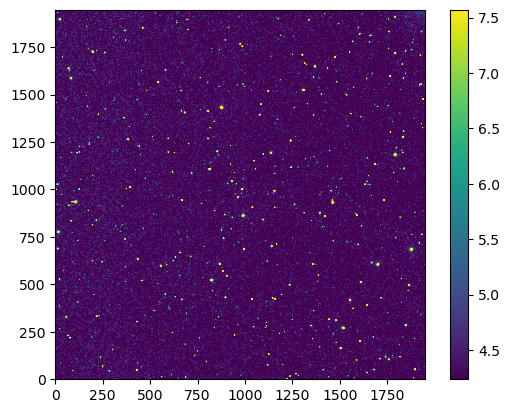

In [ ]:

pirate_image_number = 1  # Specify the pirate image number to open

print(os.getcwd())
print(os.path.isfile(f'reduced_pirate_data/PIRATE_{pirate_image_number}_OSL_ROE_EXO1_WASP135b_Filter_R.fits'))
print(os.listdir('reduced_pirate_data'))
hdul = fits.open(f'reduced_pirate_data/PIRATE_{pirate_image_number}_OSL_ROE_EXO1_WASP135b_Filter_R.fits') # Open the FITS file
hdul.info()  # Print a summary of all HDUs (Header/Data Units)

# Access the primary data
data = hdul[0].data
header = hdul[0].header

# View basic info
print(header)
print(data.shape)
print(data)

# Close when done
hdul.close()
fits_file = fits.open(f'reduced_pirate_data/PIRATE_{pirate_image_number}_OSL_ROE_EXO1_WASP135b_Filter_R.fits')  # open fits file as fits_file
image_data = fits_file[0].data  #print(fits_file)
#print(image_data)

# x1 sets image "brghtness"
x1 = 99

vmin = np.median(image_data)
vmax = np.percentile(image_data, x1)
plt.figure()
plt.imshow(image_data, origin='lower', vmin=vmin, vmax=vmax)
plt.colorbar()
plt.show()



### <div style="height:50px"></div>

### DATA REDUCTION: 

#### • First we grayscale the FITS Images:

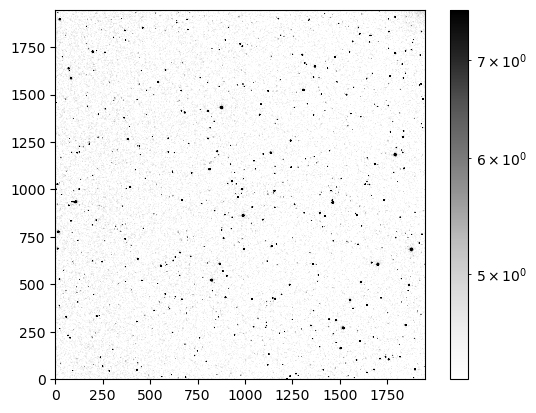

In [3]:
plt.figure()
plt.imshow(
    image_data,
    origin='lower',
    cmap='Greys',
    norm=LogNorm(vmin=np.median(image_data), vmax=np.percentile(image_data, x1))
)
plt.colorbar()
plt.show()

#### • Using the DAOStarFinder package we Identify individual stars, assigning an ID to each ("Actual" star names are not used). We then find mean (centroid) positions in X and Y Pixels and use DAOStarFinder to find their flux (with Sky subtracted as a median? ***Might not be ther correct way of doing this***) and Magnitude:

In [4]:

mean, median, std = sigma_clipped_stats(image_data, sigma=3.0)
print(f"Mean: {mean}, Median: {median}, Std: {std}")
star_threshold = 100
daofind = DAOStarFinder(fwhm=3.0, threshold=star_threshold*std)
sources = daofind(image_data - median)
print(sources)

#ID - Assigns each star a unique identifier
#xcentroid, ycentroid - The x and y pixel coordinates of the star's

for cal in sources.colnames:
    if cal not in ('id', 'npix'):
        sources[cal].info.format = '%.2f'  

sources.pprint(max_width=80)


Mean: 4.236440181732178, Median: 4.2289958000183105, Std: 1.3140753507614136
 id     xcentroid          ycentroid      ...    flux      mag     daofind_mag 
--- ------------------ ------------------ ... --------- ---------- ------------
  1 430.29954969179005  48.44175109648476 ... 1837.7501  -8.160716    -1.085129
  2 1412.5343821133474  48.89409477715649 ...  658.3555  -7.046151 -0.113346055
  3  1894.988684116461  50.26991258043571 ... 2992.7104  -8.690162   -1.7583351
  4  1587.090415508283  99.76819140923354 ...  863.7635  -7.340987   -0.4089096
  5 1756.1173977142594 102.65941223762098 ... 3147.1272  -8.744785   -1.7827213
  6 1709.5998538151402 107.17349231100702 ... 767.85724  -7.213201   -0.2529934
  7 1739.4589719703533 117.30045762269181 ...  976.6527 -7.4743505   -0.4120065
  8 1503.1339909489063 162.12396631340394 ...  4296.369  -9.082754    -2.205238
  9  1605.558759575284  198.9917685549376 ... 713.68164  -7.133761  -0.17498368
 10 1519.4682314709203  266.5624341782104 .

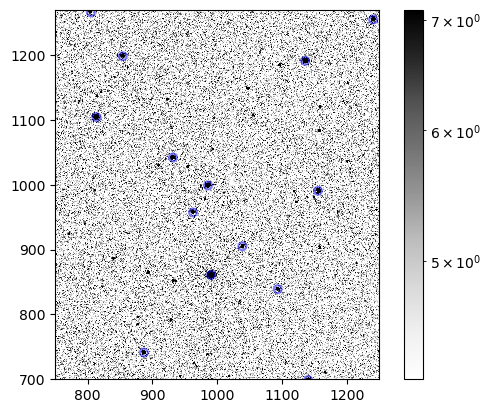

In [5]:
from matplotlib.colors import LogNorm
from photutils.aperture import CircularAperture

x2 = 98
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
apertures = CircularAperture(positions, r=6)
plt.imshow(image_data, origin='lower', cmap='Greys', norm=LogNorm(vmin=np.median(image_data), vmax=np.percentile(image_data, x2)), interpolation='nearest')
apertures.plot(color='blue', lw=1.5, alpha=0.5)
plt.xlim(750, 1250)  # x-axis pixel range
plt.ylim(700, 1270)  # y-axis pixel range
plt.colorbar()
plt.show()

#Masks dont appear to be necessary for the data?



#### • We then apply Aperture Photometry in the relevant area around WASP, Identifying the brightest objects in the area (of which WASP is one). Using the Photutils.aperture package, functions are applied to create an aperture and annulus to calculate a Sky background value around each object and an aperture sum:

(950.0, 1060.0)

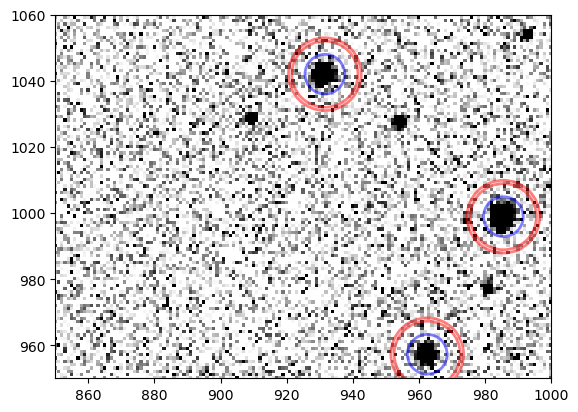

In [6]:
from photutils.aperture import CircularAperture, CircularAnnulus, aperture_photometry, ApertureStats
annulus_aperture = CircularAnnulus(positions, r_in=10, r_out=11)

plt.figure()
plt.imshow(image_data, origin='lower', cmap='Greys', norm=LogNorm(vmin=np.median(image_data), vmax=np.percentile(image_data, x2)), interpolation='nearest')
apertures.plot(color='blue', lw=2, alpha=0.5)
annulus_aperture.plot(color='red', lw=2, alpha=0.5)
plt.xlim(850, 1000)  # x-axis pixel range
plt.ylim(950, 1060)  # y-axis pixel range


In [7]:
# Define your zoom region
x_min, x_max = 900, 1100
y_min, y_max = 950, 1150

# Filter sources to only those within the zoomed region
mask = (
    (sources['xcentroid'] >= x_min) & (sources['xcentroid'] <= x_max) &
    (sources['ycentroid'] >= y_min) & (sources['ycentroid'] <= y_max)
)
filtered_sources = sources[mask]

# Use only the filtered positions for aperture photometry
filtered_positions = np.transpose((filtered_sources['xcentroid'], filtered_sources['ycentroid']))
filtered_apertures = CircularAperture(filtered_positions, r=8)
filtered_annulus_aperture = CircularAnnulus(filtered_positions, r_in=10, r_out=11)

aperstats = ApertureStats(image_data, filtered_annulus_aperture)
bkg_mean = aperstats.mean
aperture_area = filtered_apertures.area_overlap(image_data)
total_bkg = bkg_mean * aperture_area

star_data = aperture_photometry(image_data, filtered_apertures)
star_data['total_bkg'] = total_bkg

for col in star_data.colnames:
    star_data[col].info.format = '%.8g'

star_data.pprint()

 id  xcenter   ycenter  aperture_sum total_bkg
--- --------- --------- ------------ ---------
  1 962.49957 957.26299    2643.0761 886.54449
  2 985.53631  998.8738    4894.5926 932.73433
  3  931.5476 1041.9625    3417.8827 900.72666


#### • We now calculate a magnitude for each of these stars using the equation [m = Filter_Zp - 2.5log_10( (aperture_sum - background) / exposure_time )]:

In [8]:
#finding info from header of .fits files
#Type in termial: more 'filename'
exptime = 60
filter_zpt = 25.123 # ***TRIAL ZERO POINT- NEED TO GET REAL VALUE!***


magnitudes = []
for line in star_data:
    magnitudes.append(filter_zpt - 2.5 * math.log10((abs(line['aperture_sum'] - line['total_bkg'])) / exptime))

star_data['magnitude'] = magnitudes
star_data.pprint()


 id  xcenter   ycenter  aperture_sum total_bkg     magnitude     
--- --------- --------- ------------ --------- ------------------
  1 962.49957 957.26299    2643.0761 886.54449 21.456738202691042
  2 985.53631  998.8738    4894.5926 932.73433 20.573630800058584
  3  931.5476 1041.9625    3417.8827 900.72666 21.066102783672967


### <div style="height:50px"></div>

### COMPARISON STARS:

#### *** INSERT DESCRIPTION OF WHY WE USE STANDARD STARS HERE ***

#### • IDENTIFYING COMPARISON STARS:

###### First the cell opens the first FITS file and uses that image as the reference for finding sources. It computes sigma‑clipped statistics (mean, median, std) on the reference image and runs DAOStarFinder with an FWHM and threshold based on the clipped std to produce a table of detected sources; the source table contains centroid coordinates (xcentroid, ycentroid) for every detection.

###### Next the code builds arrays of positions from the detected centroids and runs aperture photometry on every detected source in the reference image using a circular aperture and a circular annulus. From the photometry tables it extracts aperture sums and annulus sums and computes an annulus area and aperture area. It converts annulus sum to a background estimate for each aperture (by scaling annulus sum to the aperture area) and subtracts that background from the aperture sum to get background‑subtracted flux for each detected source in the reference image; these background‑subtracted values are stored in net_fluxes.

###### Then the code identifies which detected source corresponds to the target star by computing distances from each detected centroid to the provided target_xy and taking the source with the minimum distance as the target. It records the target’s net flux (target_flux) from the reference‑image photometry.

###### To choose comparison stars it expands a search radius around the target. For increasing radii it finds detections within that radius (excluding the target), computes their flux relative to the target, and selects those whose relative flux lies between flux_lower and flux_upper. If enough similar stars are found within the current radius, it picks the nearest n_comp of them and stops. If the loop finishes without enough matches, the code falls back to a simpler selection: it considers all candidates (excluding the target), prefers candidates that are equal‑or‑brighter than the target and picks nearest brighter ones first, and then fills any remaining slots with the nearest remaining candidates. The result is a list sel_positions where the first entry is the target and the following entries are the chosen comparison star coordinates.

###### With the selection fixed, the cell allocates a 2D array lightcurves of shape (n_stars, n_images). It constructs photometric aperture and annulus objects for all selected positions, then loops over every FITS file. For each image it runs aperture_photometry once on the full list of selected positions to get aperture sums and annulus sums, computes background estimates by scaling annulus sums to aperture area, subtracts background to get net flux for each selected star, and stores those net fluxes in the corresponding column of the lightcurves array. This produces one background‑subtracted flux time series per star.

###### After collecting fluxes for all images the code normalizes each star’s light curve by its median value so each series has median = 1; this makes relative variations easy to compare. It then plots the normalized light curves with the target plotted in black and the comparison stars in lighter colors. Finally the function returns the selected positions, the raw (background‑subtracted) lightcurves, and the normalized lightcurves and also prints/stores comparison_positions (the comparison‑only coordinates).

###### A later cell contains a separate, simpler routine that instead of selecting comparisons from the reference image uses a hard‑coded list of approximate comp_positions. For each position it loops over every FITS file, runs source detection on that image, finds the detected source closest to the expected coordinate, measures that star’s aperture sum with ApertureStats (but that cell does not subtract background), appends the aperture sum for each image to a per‑star list, and then plots that list. That approach works but is slower (it runs detection per image and per star) and risks errors if detection fails in some images; the earlier vectorized method (aperture_photometry on all positions per image with annulus background subtraction) is preferable when possible.

###### If you re‑run this in future, check for None/empty returns from DAOStarFinder before indexing, ensure annulus radii avoid neighboring stars, and prefer the vectorized aperture_photometry loop for speed and consistent background subtraction.

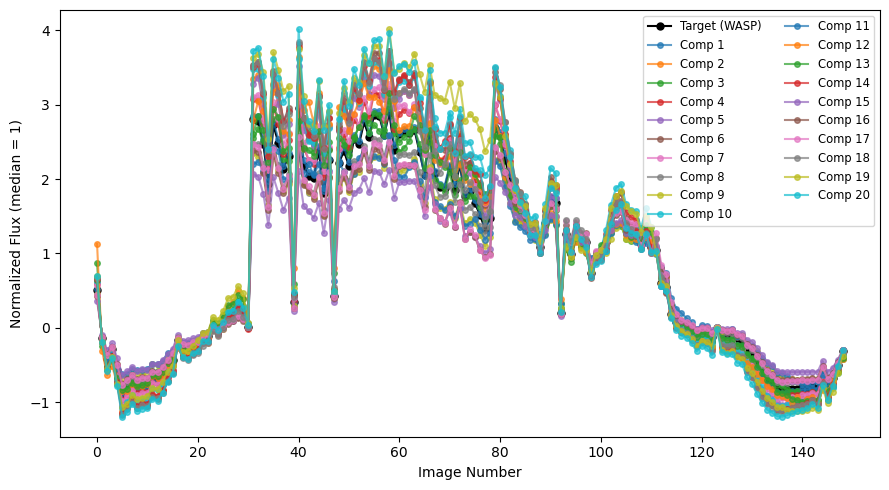

Selected positions (x, y) — first entry is the target:
Target: x = 1012.50, y = 1007.26
Comp 1: x = 1035.54, y = 1048.87
Comp 2: x = 981.55, y = 1091.96
Comp 3: x = 1040.42, y = 910.84
Comp 4: x = 1205.22, y = 1040.60
Comp 5: x = 863.40, y = 1154.41
Comp 6: x = 904.30, y = 1248.22
Comp 7: x = 1185.55, y = 1241.23
Comp 8: x = 1190.02, y = 748.90
Comp 9: x = 917.02, y = 656.19
Comp 10: x = 1290.27, y = 1304.76
Comp 11: x = 874.83, y = 570.38
Comp 12: x = 926.41, y = 1479.57
Comp 13: x = 1511.97, y = 978.99
Comp 14: x = 732.93, y = 1452.55
Comp 15: x = 947.26, y = 479.41
Comp 16: x = 607.19, y = 646.58
Comp 17: x = 484.97, y = 682.87
Comp 18: x = 432.02, y = 1312.78
Comp 19: x = 1357.99, y = 1571.72
Comp 20: x = 592.89, y = 1614.22

Comparison star positions (x, y): [(1035.539235526542, 1048.8740658400036), (981.5477720636381, 1091.960150452481), (1040.4239208313975, 910.8413387532294), (1205.2150373243046, 1040.6032037481832), (863.4030438149781, 1154.410546269273), (904.2955926328444, 1

In [ ]:
# Aperture Photometry to find 20 stars around WASP-135b with similar brightness and plot their light curves

def find_and_plot_comparisons(fits_files, target_xy, n_comp=20,
                              aperture_radius=5, ann_in=8, ann_out=12,
                              start_radius=30, max_radius=500, radius_step=10,
                              flux_lower=0.90, flux_upper=1.20,
                              nsigma_detect=3.0, fwhm=3.0):
    """
    Find comparison stars by expanding a radius around target until n_comp stars
    are found with flux in the range [flux_lower * target_flux, flux_upper * target_flux].
    Then compute and plot light curves (normalized by median).

    - flux_lower, flux_upper : relative bounds (e.g. 0.9 -> 10% fainter, 1.2 -> 20% brighter)
    """
    # reference image for source finding and selection
    with fits.open(fits_files[0]) as ref_hdul:
        ref_image = ref_hdul[0].data

    mean, median, std = sigma_clipped_stats(ref_image, sigma=3.0)
    daofind = DAOStarFinder(fwhm=fwhm, threshold=nsigma_detect * std)
    sources = daofind(ref_image - median)
    if sources is None or len(sources) == 0:
        raise RuntimeError("No sources found in reference image.")

    positions_all = np.transpose((sources['xcentroid'], sources['ycentroid']))

    # photometry on reference image to get fluxes (background-subtracted)
    apertures_all = CircularAperture(positions_all, r=aperture_radius)
    annuli_all = CircularAnnulus(positions_all, r_in=ann_in, r_out=ann_out)
    ap_table = aperture_photometry(ref_image, apertures_all)
    ann_table = aperture_photometry(ref_image, annuli_all)

    ann_area = math.pi * (ann_out**2 - ann_in**2)
    ap_area = math.pi * (aperture_radius**2)

    ap_sums = ap_table['aperture_sum'].data
    ann_sums = ann_table['aperture_sum'].data
    net_fluxes = ap_sums - (ann_sums / ann_area) * ap_area

    # find index of target in sources (closest to provided target_xy)
    dx = sources['xcentroid'] - target_xy[0]
    dy = sources['ycentroid'] - target_xy[1]
    dists = np.hypot(dx, dy)
    target_idx = np.argmin(dists)
    target_flux = net_fluxes[target_idx]

    # expand radius to find n_comp similar stars within flux bounds
    comp_indices = []
    for R in range(start_radius, max_radius + 1, radius_step):
        within_R = np.where((dists <= R) & (np.arange(len(dists)) != target_idx))[0]
        if within_R.size == 0:
            continue
        rel_flux = net_fluxes[within_R] / target_flux
        # select those within the specified relative flux interval
        similar_mask = (rel_flux >= flux_lower) & (rel_flux <= flux_upper)
        similar = within_R[similar_mask]
        if similar.size >= n_comp:
            # pick nearest n_comp of those
            sim_dists = dists[similar]
            order = np.argsort(sim_dists)
            comp_indices = list(similar[order[:n_comp]])
            break

    # if not enough found, fall back to nearest stars (excluding target) but prefer brighter/equal
    if len(comp_indices) < n_comp:
        candidates = np.where(np.arange(len(dists)) != target_idx)[0]
        # prefer candidates with rel_flux >= 1.0 (equal/brighter) first, then others
        rel_all = net_fluxes[candidates] / target_flux
        brighter_mask = rel_all >= 1.0
        brighter = candidates[brighter_mask]
        if brighter.size >= (n_comp - len(comp_indices)):
            order_b = np.argsort(dists[brighter])
            need = n_comp - len(comp_indices)
            comp_indices.extend(list(brighter[order_b[:need]]))
        else:
            # take all brighter then fill with nearest remaining
            comp_indices.extend(list(brighter[np.argsort(dists[brighter])]))
            remaining_needed = n_comp - len(comp_indices)
            remaining_candidates = np.setdiff1d(candidates, np.array(comp_indices))
            order_rem = np.argsort(dists[remaining_candidates])
            comp_indices.extend(list(remaining_candidates[order_rem[:remaining_needed]]))

    # final selected positions: target first, then comps
    sel_indices = [target_idx] + comp_indices[:n_comp]
    sel_positions = positions_all[sel_indices]

    # Prepare arrays to store light curves
    n_images = len(fits_files)
    n_stars = len(sel_positions)
    lightcurves = np.zeros((n_stars, n_images))

    apertures_sel = CircularAperture(sel_positions, r=aperture_radius)
    annuli_sel = CircularAnnulus(sel_positions, r_in=ann_in, r_out=ann_out)

    for j, fits_file in enumerate(fits_files):
        with fits.open(fits_file) as hdul:
            img = hdul[0].data
        ap_tab = aperture_photometry(img, apertures_sel)
        ann_tab = aperture_photometry(img, annuli_sel)

        ap_sum = ap_tab['aperture_sum'].data
        ann_sum = ann_tab['aperture_sum'].data
        net = ap_sum - (ann_sum / ann_area) * ap_area
        lightcurves[:, j] = net

    # normalize each light curve by its median for plotting
    norm_lc = lightcurves / np.median(lightcurves, axis=1)[:, None]

    # Plot: target in black, comps in lighter colors
    plt.figure(figsize=(9, 5))
    x = np.arange(n_images)
    plt.plot(x, norm_lc[0], 'o-', color='k', markersize=5, label='Target (WASP)')
    for i in range(1, n_stars):
        plt.plot(x, norm_lc[i], 'o-', markersize=4, alpha=0.7, label=f'Comp {i}')
    plt.xlabel('Image Number')
    plt.ylabel('Normalized Flux (median = 1)')
    plt.legend(ncol=2, fontsize='small', loc='best')
    plt.tight_layout()
    plt.show()

    return sel_positions, lightcurves, norm_lc

sel_positions, raw_fluxes, normalized_fluxes = find_and_plot_comparisons(
    fits_files, (target_x, target_y), n_comp=20, aperture_radius=5,
    flux_lower=0.95, flux_upper=1.50
)



# Print selected positions (first entry is the target)
print("Selected positions (x, y) — first entry is the target:")
for i, (x, y) in enumerate(sel_positions):
    role = "Target" if i == 0 else f"Comp {i}"
    print(f"{role}: x = {x:.2f}, y = {y:.2f}")

# Store comparison-only positions if needed
comparison_positions = [tuple(map(float, p)) for p in sel_positions[1:]]
print("\nComparison star positions (x, y):", comparison_positions)


#### • We then take the approxomate initial positions for each star and plot their apperture sums to compare with the WASP lightcurve

[127352.53392013132, 84863.14389378483, 214121.5353557437, 87392.27531474415, 257948.725089425, 94580.28362827352, 94632.20444574267, 343710.7503003685, 344850.21636080317, 336530.29803744575, 344847.9389425741, 345156.33433470875, 92565.03791337422, 342612.7811673981, 92614.37498182512, 92636.86116241214, 233155.82473597408, 318613.4800952343, 342101.82748987613, 342803.5513553773, 343524.57441885734, 92682.16170443998, 345062.6068661216, 325534.159954964, 344189.5072244003, 335458.94950951525, 342308.8248227368, 93906.7980228571, 328082.16145790153, 342007.2272485963, 146733.5187099873, 342084.28901205387, 334470.4586197943, 317529.5048755569, 263049.1617529877, 336355.87725727644, 309187.5786993571, 283927.66196862556, 297952.1460470641, 122550.62019623343, 332658.02891769895, 277498.3292899472, 263121.5498952974, 261010.12890875209, 291970.70164737245, 247827.98950823423, 281467.89684915694, 141868.79291243243, 276536.61352725915, 291693.53220205073, 276672.4985082559, 304363.44442

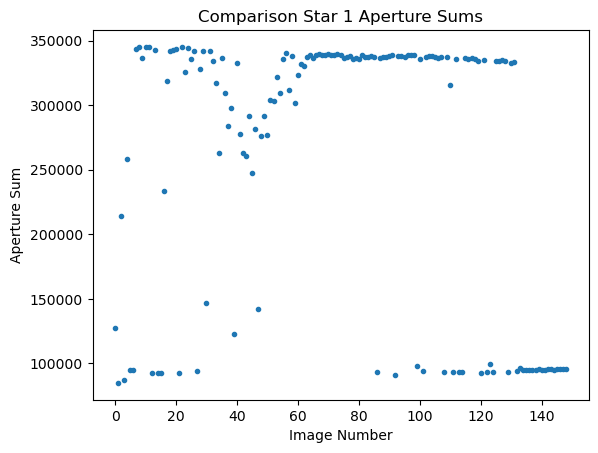

[147771.69808379887, 84906.32993791897, 277581.67592777323, 212734.757455799, 90380.01963212664, 462347.27836057806, 463972.32165916654, 92713.63930485782, 459388.7073830388, 458856.2157193682, 460253.2922508089, 452482.63661099755, 452326.41673265735, 450410.0382783268, 460966.82278888125, 468083.1699787869, 304103.14405434474, 427624.2591193724, 470588.2666732642, 472939.01244813495, 472253.8341060395, 461040.254570315, 473715.61472160724, 445063.6256940174, 473808.7413853623, 460411.22595183377, 468296.63093086093, 462773.11909981555, 448433.78344758076, 467020.18487221724, 174360.71181295477, 467592.2484888245, 460675.31843726477, 434487.76377266645, 347934.037054391, 463930.88197096856, 420650.0200429866, 383948.03881641186, 399791.8939065876, 138844.51986479602, 450874.24047738797, 371267.42180824536, 351433.9065743156, 345464.2271297855, 397368.62214498897, 327481.3431220979, 380031.5579360832, 159291.9737073458, 369332.4870327608, 396201.0015265792, 371383.8552161367, 415326.01

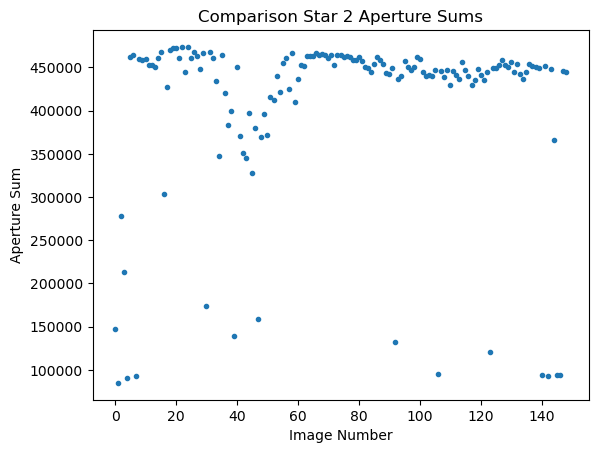

[330523.13166384824, 329135.77339747787, 678797.505094988, 529040.1987379757, 91809.1625653953, 94779.42212733965, 94456.17895440604, 987366.2856410813, 921773.3950391037, 94513.49022743588, 931071.1124231389, 903214.2625651495, 911435.2039159904, 916062.7422615236, 926822.1736572989, 943423.5467383694, 718291.0473243087, 884224.7767309176, 984423.6504160007, 1021762.4379872263, 972829.9370787452, 94364.55290633133, 1005456.6904331159, 924484.5734087588, 983501.6454655123, 994227.7317679991, 987227.4591694025, 1040275.6303161929, 1008866.4531398088, 1006435.7433977267, 416199.10658959206, 958454.6900940631, 950287.266811083, 938457.854099275, 825021.2222588536, 1036634.3117357775, 981749.8153468339, 846775.5410933387, 838083.5144651578, 275166.0108300248, 94465.9945119294, 808553.9144486464, 851792.8970593223, 784621.3170204608, 872107.9335466557, 763995.9694110388, 849954.9703218323, 322027.1910684447, 886585.0028706524, 844316.7056215832, 813525.0676330092, 855165.8377485999, 940347.

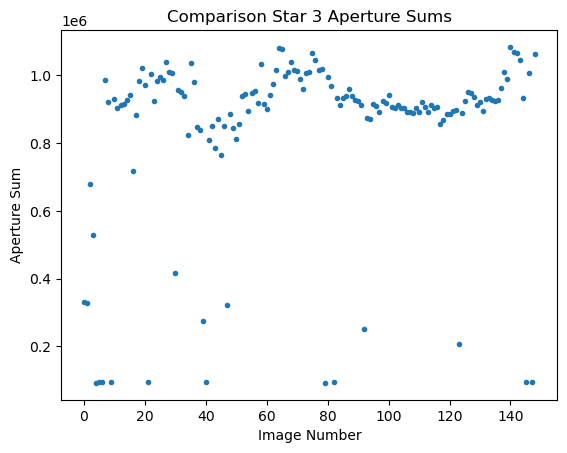

[112665.43322004472, 111152.45495525475, 170100.96448631093, 140313.81434716232, 199254.1778015276, 256805.27420068675, 256048.5245800136, 256259.15766193284, 256377.3175362932, 250708.9657326236, 124610.82285925359, 255661.4292237614, 255745.43426317204, 92540.39667246217, 255575.8254555638, 92665.45474660442, 184130.28025388104, 239234.93721213232, 254167.3793569163, 255643.57093209756, 255294.28498524375, 250948.1024838104, 255605.71346338585, 244339.6314624408, 256043.20503231484, 250896.0041729329, 254182.98175037012, 251601.9890693117, 245184.39380091272, 253917.2948424251, 127297.0337617718, 255817.42987976258, 250125.5876975738, 238836.703803144, 205017.46320766956, 251070.42901317618, 233968.28393724677, 217976.11565489633, 227187.35632749618, 111956.93031270104, 249132.85147807238, 214311.76048501162, 203957.1933531298, 202549.55314968372, 223166.72134041815, 195146.31208860784, 214836.9214002459, 128987.36786307044, 213534.73972684675, 222773.40910902384, 214627.82955413003,

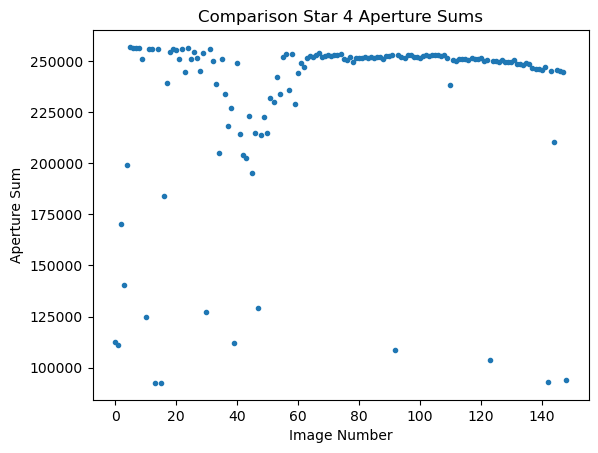

[136828.05513787182, 135590.3809600032, 88962.99442182572, 188952.4907045265, 91024.1203861767, 93248.88147347546, 93004.82921948335, 93168.77866396609, 94448.08348104122, 93003.19444271494, 92628.90551953488, 396946.5393109195, 92704.10000270164, 92424.69345375465, 402717.60397759324, 400339.8767353664, 263802.18398489914, 371917.49347480154, 400200.67551070056, 402386.15618011, 401712.39370571694, 391458.5920497247, 92661.38335057822, 378954.180738693, 402406.37730297184, 390978.55019814766, 399567.67412927316, 394761.0735486759, 380784.3258630909, 398498.75332103693, 160018.79563034847, 401029.61104728404, 391991.2992796685, 370227.9364714957, 297813.7392291881, 392635.58111567807, 361736.91382172896, 335160.08431738755, 346916.84656641766, 131694.42953614934, 388525.04851462523, 323080.6916484063, 298556.34769939224, 299108.1916995751, 341683.73035204917, 287797.019276234, 320107.8739889016, 146332.08605756718, 314486.9031848913, 338452.39640982274, 324953.707580427, 355950.7839513

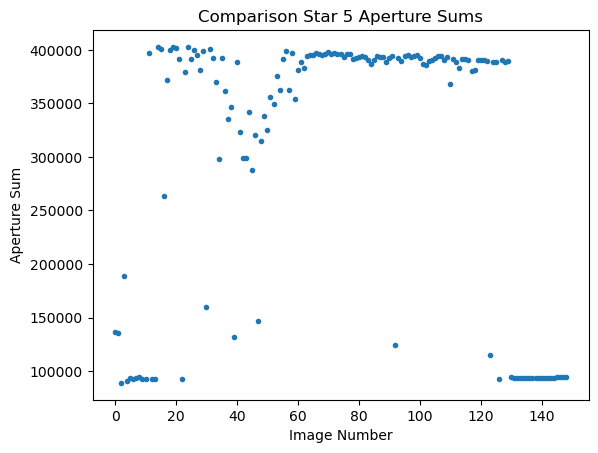

[116592.74707985189, 115127.94972562868, 88782.92534113953, 147931.38651884726, 90538.1319533286, 280057.6590063718, 279651.05670945294, 280488.2541907296, 92034.05905823715, 275587.3812363641, 91847.12884407857, 280709.64113311295, 280430.9762301422, 92113.94817007118, 280360.69129611616, 277669.6471508313, 196425.29897125374, 261542.8954505506, 278501.2974332683, 279277.870280031, 278454.20080954564, 273788.49269011273, 278346.5291752049, 265755.8889023311, 279485.8619007357, 272495.93603196787, 279065.7485365596, 275095.84050732944, 267282.2479292855, 278075.57285120036, 132998.96465529516, 279187.85085286153, 273974.1634113213, 260093.44830136065, 216505.6444758498, 273935.8528541236, 256061.99138019473, 242577.85783081362, 247319.3551944855, 115887.04363249517, 270601.6127395863, 233129.65673732394, 218604.59495670116, 217662.5194051798, 244710.5213850819, 212046.57591906757, 230024.44675355882, 129584.54278457139, 227448.8631565871, 241263.87370307016, 234201.96988022255, 253089.

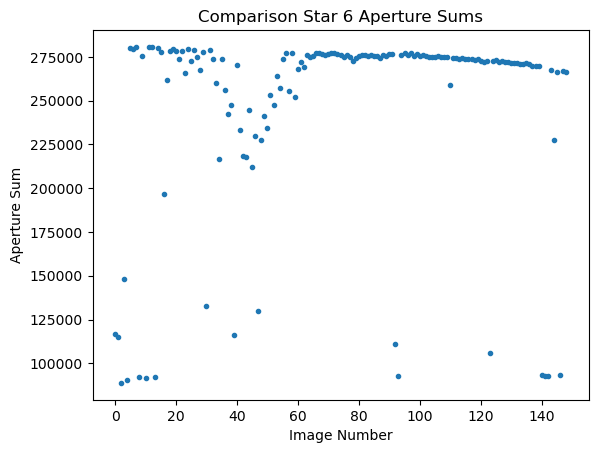

[416385.4751844712, 415112.47562592564, 833518.6294593308, 628015.4430415895, 955429.6059618136, 93672.03066962403, 1169996.8603369955, 1169114.3817795238, 1099890.6580920352, 1093577.0865879625, 1103079.720770747, 1092800.5228596558, 93924.65561546535, 1113989.1863616847, 95265.39091687181, 1148633.8826023384, 859583.8813184352, 1030993.8887294739, 1168259.7765714843, 1215224.9811248796, 94575.62478832225, 1109816.6149724694, 1205088.8103874177, 92956.27366560316, 95294.32049717019, 1157368.010998347, 1161083.6532160803, 1223016.761313925, 1208676.6843899253, 1174144.7687434133, 518129.5122138715, 1119116.0763707599, 1142311.1411375303, 1154599.7841405668, 954091.344658288, 1232727.3481245416, 1191449.019269768, 94346.02167901224, 94381.99168263486, 354626.7879761745, 1077325.8221308293, 1004995.0913315407, 1011163.728251882, 936267.8150677363, 1068828.0830066074, 95784.5038728169, 972569.9498106833, 353866.99526302103, 1020942.6277351652, 97136.23671765551, 935545.8999994487, 1011197

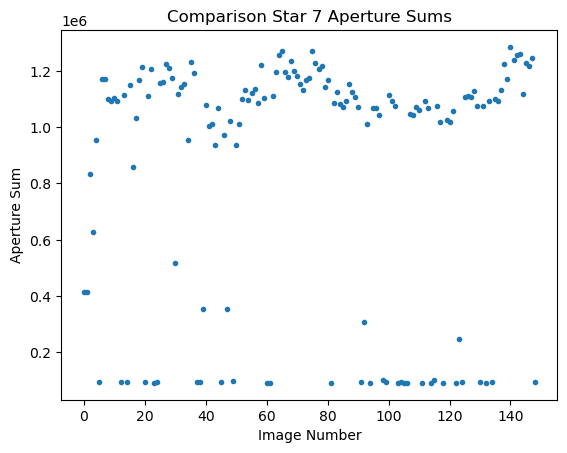

[118673.994408612, 117363.8661691471, 88524.29085617467, 152457.57705941662, 224106.4543691773, 294758.3507759466, 293301.6554199466, 294373.96955527377, 294455.7526560195, 287817.1427728204, 293782.58439575194, 96515.64828639878, 293468.25290540745, 293633.28929407784, 293889.24753847823, 291275.5691269836, 205611.93237039243, 273499.82227348577, 292970.85474333126, 292299.2515991825, 292578.96893103566, 288178.778616307, 292154.54876905883, 279975.7390007105, 293579.8037553823, 286741.73832757893, 290121.64938883536, 287879.2279970752, 281215.7737336006, 291531.6077159772, 135377.79957966876, 292185.7911504824, 286281.70248853223, 272190.3989880567, 231176.72052019188, 288895.38984177366, 265656.3110154648, 245247.31233193664, 258484.33535937886, 116008.83842993047, 284267.75561435294, 242997.45418052192, 229888.456444682, 229851.0554362962, 249677.55226944992, 214376.8419397318, 247627.56148095627, 135126.93754104056, 245194.38446735142, 252618.98550338615, 242955.7577208096, 261878

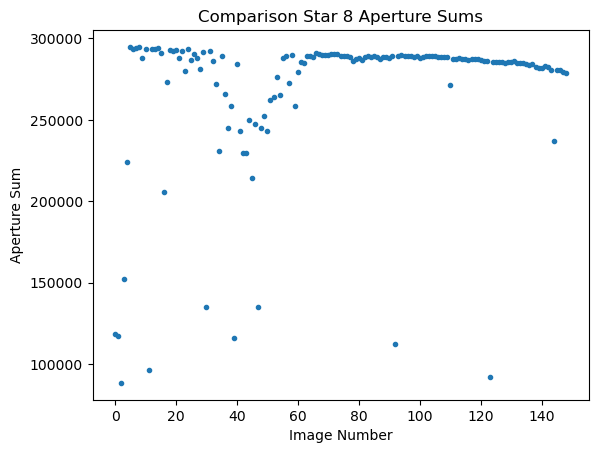

[160698.89982596648, 159558.16593007284, 89483.86490335496, 237657.90444035057, 90707.17487999875, 502583.31978097896, 529700.5634642154, 517827.6636887459, 507593.74517236545, 506228.9226028399, 506306.20424187864, 492278.6109148587, 495253.28950681555, 499540.7952467829, 505790.550056079, 515239.06294958474, 346072.75716406654, 471275.8252224178, 518701.3996561052, 532805.9115220438, 525646.126274589, 513422.0105448978, 531357.8816346433, 512453.57506087184, 537668.7817111153, 523836.58191751235, 515478.3811579757, 535038.7250053656, 513837.448756245, 524756.3359741655, 193899.64031288007, 529845.825274755, 510540.09535207815, 486449.6507465802, 394234.4174579865, 530513.3859724456, 478831.1029704627, 433624.15979968663, 449824.8619878355, 147341.97227165857, 499615.0191117093, 433201.5893519623, 410430.629561586, 401113.73866680946, 444157.6405390224, 361393.132686974, 453271.6577588902, 175337.75533004972, 431831.1102499624, 447720.1034913562, 415989.9557127853, 457734.5759672699, 

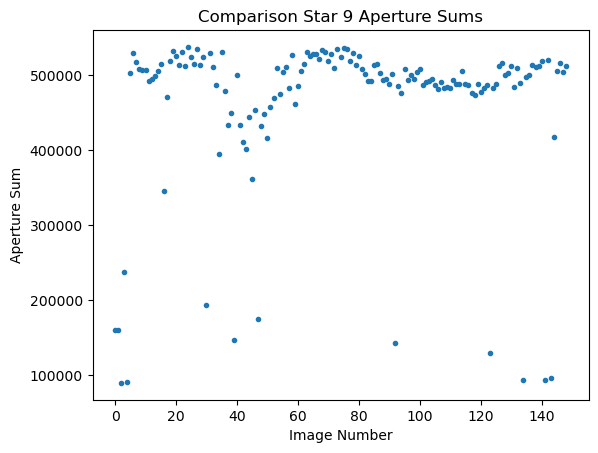

[306993.7057592377, 304535.06078706385, 645049.5570395627, 491704.93261600187, 97319.7973158546, 863082.28028693, 93000.45993015275, 913442.4503629059, 876643.8073778948, 93887.93523665427, 874586.9184614356, 863557.7891106189, 863598.3527821715, 884203.3326691964, 847628.5718780513, 879918.7078437743, 649285.9683433505, 806720.2139670636, 914220.7749295551, 935588.0370597956, 920397.0229028399, 895341.4783895052, 949205.6135851768, 867922.7994888952, 933101.6233650828, 947461.40806345, 96896.23045674966, 991321.6370476651, 955688.9780003061, 943991.6311566454, 383421.7129062017, 909689.7571958391, 892165.9816201846, 877357.1588426444, 739757.975580396, 984102.4580197938, 931588.7755316872, 816584.5659244406, 820840.4733459338, 248073.59893667055, 864314.2744584796, 789560.8039807617, 819336.1734661848, 773807.6575015452, 827828.752469681, 709084.2458343515, 814388.9463542083, 314009.6868847967, 838020.0396939623, 800734.7893539057, 743119.2553310532, 794548.0055129171, 884115.55372533

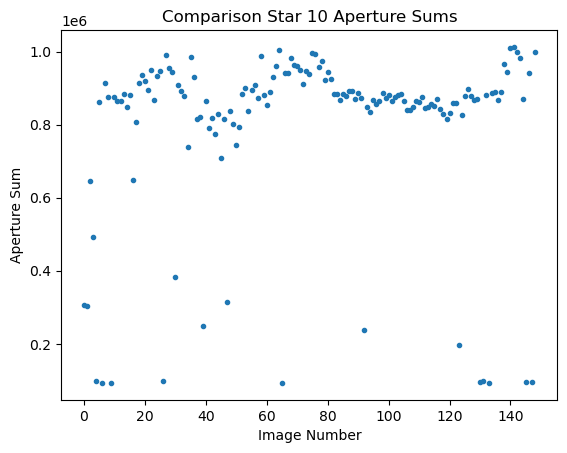

[210248.85757188746, 94176.75657756312, 117564.20396095219, 105586.54792324673, 128523.31906662941, 150428.66326125895, 150290.05495970833, 149982.4838958476, 150443.15603010566, 148925.44642898606, 150060.23557101408, 149535.57821690125, 150132.04078007117, 149565.66786217803, 150120.89817677776, 149468.58086099234, 128272.44525415666, 145424.3671237943, 149553.41742417237, 149709.97539131105, 149738.60257062793, 148212.63839946367, 150093.17812678614, 146209.33810999856, 150000.7456332672, 148815.38853610016, 149765.27350204793, 148884.4317539328, 146329.6107700547, 149072.50711770443, 103900.7549958836, 676306.9374308139, 702442.9741655318, 675180.399944633, 564230.1147127763, 733792.7007608421, 688950.0716323642, 602758.0857185972, 614088.4314767009, 189006.20481537195, 652954.4903360835, 586923.6765326065, 571056.4432499153, 559876.462962262, 627933.5095439664, 536924.9713914676, 585919.2533654943, 208063.54454046817, 611564.1271453148, 595499.0438635297, 569838.8802169785, 616986

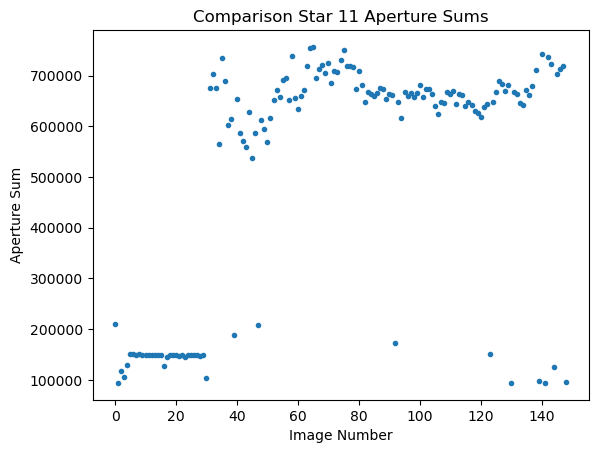

[121997.63599593598, 120592.45762298972, 197328.93968809166, 86664.57568264153, 237220.20171645537, 313394.8563275807, 312078.10727919213, 313283.10004405526, 313751.0306785771, 92675.51566488203, 313023.6536052993, 314142.6012292581, 313876.441378813, 312491.7387752327, 313360.6337089161, 310841.9656043348, 219257.86432933828, 287643.46572596306, 312063.89285137487, 313136.35901845334, 312061.37040544575, 307982.02267385955, 313699.8110298697, 299500.6219421129, 313595.8937017182, 309062.353903303, 310824.1172288958, 308061.4680453883, 300698.891124051, 311472.7285692146, 139301.2117529037, 312187.97925410105, 304718.89356773644, 289003.39295388357, 237924.05595523308, 308909.76599744125, 282317.0676328368, 262593.1258540908, 275692.6571469387, 116847.22675293058, 303952.8846681225, 259798.9743615295, 251060.18006226898, 243006.64861101838, 262733.8758046103, 224403.75380503386, 271001.31716408464, 140041.97804420203, 253046.6897386939, 268738.2321429831, 254890.9964016664, 276215.703

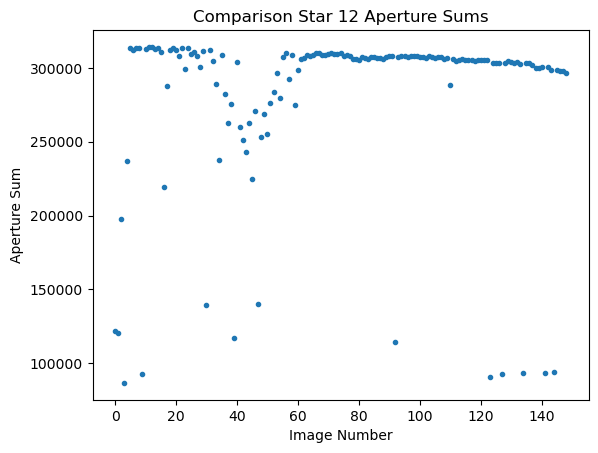

[114234.93207132173, 112849.14206672361, 175143.0335591443, 86388.87286024915, 205874.0770266409, 266957.14803528565, 265469.22405073803, 266532.66543070937, 266187.8922711617, 259993.22083783304, 266789.20013800793, 266795.1190841761, 266153.0417991863, 266098.86319109774, 265139.69947120076, 264139.54842095263, 193136.7026529345, 245105.70780799683, 264959.95146219793, 265292.4671338662, 264937.1958241701, 260430.03793035605, 265308.15008859645, 93571.21205166231, 265871.5892406935, 259794.30821581176, 263904.79755370686, 261741.6903094159, 254381.4352636817, 263437.806021325, 128932.03826474088, 264745.33905337984, 259430.4894727098, 250083.68784158968, 207812.8618389755, 262196.53961782344, 241821.69942644684, 227240.889218728, 233276.29378685367, 112411.11209039751, 259147.91726396166, 219404.1784514612, 212192.07958472488, 207668.9392125875, 230519.2463396622, 202020.12670668517, 224498.55470180407, 129491.7088971659, 217041.16135749864, 234006.42119720206, 217885.99264624235, 23

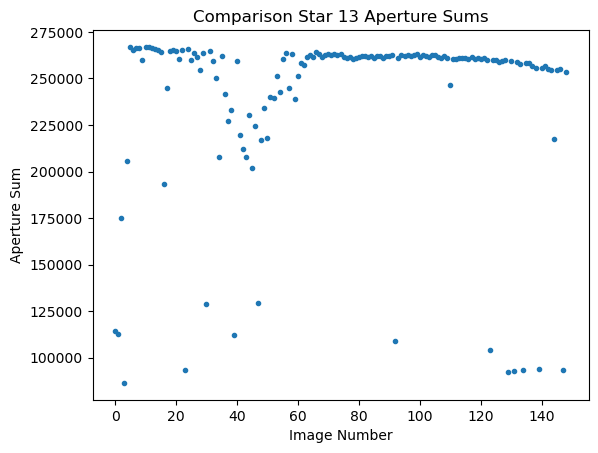

[169074.9246086098, 168057.72187774262, 342402.0729654754, 255247.81574671602, 429292.4750106944, 562691.5382573998, 584660.3756270607, 580027.2448384075, 564183.9063465662, 559697.5408346406, 569934.2769247546, 578494.030213101, 574737.6621424748, 569909.1879401895, 569308.5361183918, 568652.718434886, 369048.1110476737, 529849.7656533018, 574954.1824995738, 583957.7429612231, 582448.6016254409, 564052.9821198941, 588153.9240789635, 548280.3356575575, 582030.1861258579, 572078.5598117952, 579138.7736930614, 581739.2895912378, 564131.0388476693, 581568.9060699563, 205173.25770680935, 575856.1005530717, 563603.5711508476, 544671.2007857389, 419020.7773280195, 580276.836762743, 532841.170576199, 508889.7809595238, 510513.0672130716, 160874.0945564112, 545544.7490176144, 475826.3573282957, 425415.6779998018, 422188.4721964518, 498988.11738603876, 427410.73779259744, 454638.2457889866, 166902.21724560397, 447689.06298431626, 489226.1325339845, 467585.9955491612, 505191.7227107472, 507033.1

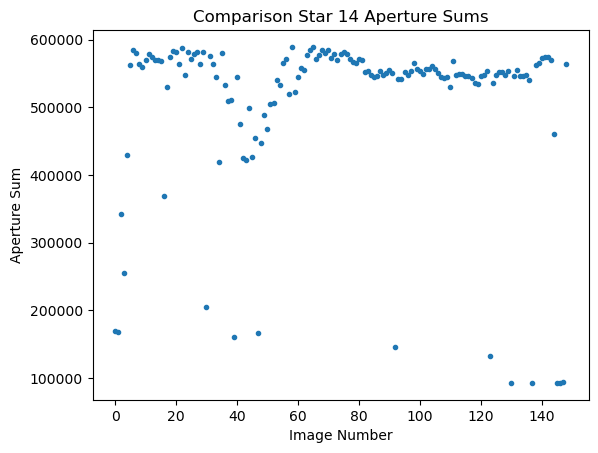

In [ ]:
# Approximate initial positions
comp_positions = [
    (1035.539235526542, 1048.8740658400036), 
    (863.4030438149781, 1154.410546269273), 
    (1040.4239208313975, 910.8413387532294), 
    (1205.2150373243046, 1040.6032037481832), 
    (1185.548814800182, 1241.233294602911), 
    (1290.272452980799, 1304.7602136176702), 
    (926.4065615137933, 1479.5726501830552), 
    (1190.0236276252197, 748.8998325181699), 
    (917.0176271749453, 656.1942454201551), 
    (874.8258295268805, 570.3829528990586), 
    (1511.966210858155, 978.9891460996301), 
    (607.1921279887127, 646.584286995316), 
    (432.02033926497853, 1312.776216668107), 
    (1357.994100309243, 1571.7237929723924), 
    (592.8851492325203, 1614.217380418922), 
    (1418.191005520548, 1695.3375288930533), 
    (1734.0735056952822, 1182.4059490864302), 
    (159.76415050133335, 982.6986499012582), 
    (1661.6486309850573, 559.9880718837447), 
    (1841.2000757823487, 1230.8646188118712)]

positions = np.array(comp_positions)
for i in range(len(positions)):
    target_x, target_y = positions[i]
    aperture_radius = 5
    fwhm = 3.0
    comparison_data = []

    for fits_file in fits_files:
        hdul = fits.open(fits_file)
        image_data = hdul[0].data
        sigma = 3

    # Detect stars in this image
        mean, median, std = sigma_clipped_stats(image_data, sigma=3.0)
        daofind = DAOStarFinder(fwhm=fwhm, threshold=sigma*std)
        sources = daofind(image_data - median)

    # Find the detected star closest to your expected position
        distances = np.sqrt((sources['xcentroid'] - target_x)**2 + (sources['ycentroid'] - target_y)**2)
        idx = np.argmin(distances)
        star_pos = (sources['xcentroid'][idx], sources['ycentroid'][idx])

    # Photometry at the detected position
        aperture = CircularAperture(star_pos, r=aperture_radius)
        aperstats = ApertureStats(image_data, aperture)
        comparison_data.append(aperstats.sum)
        hdul.close()


    print(comparison_data)
    plt.plot(comparison_data, 'o', markersize=3)
    plt.xlabel('Image Number')
    plt.ylabel('Aperture Sum')
    plt.title(f'Comparison Star {i+1} Aperture Sums')
    plt.show()

### <div style="height:50px"></div>

### LIGHT CURVE:

#### This cell is just here for comparison sake, not useful in the final analysis:

In [ ]:
# Aperture Photometry for WASP-135b

target_x, target_y = 1013, 1008  # Approximate initial position
aperture_radius = 5
fwhm = 3.0
WASP_data = []

for fits_file in fits_files:
    hdul = fits.open(fits_file)
    image_data = hdul[0].data
    sigma = 3

    # Detect stars in this image
    mean, median, std = sigma_clipped_stats(image_data, sigma=3.0)
    daofind = DAOStarFinder(fwhm=fwhm, threshold=sigma*std)
    sources = daofind(image_data - median)

    # Find the detected star closest to your expected position
    distances = np.sqrt((sources['xcentroid'] - target_x)**2 + (sources['ycentroid'] - target_y)**2)
    idx = np.argmin(distances)
    star_pos = (sources['xcentroid'][idx], sources['ycentroid'][idx])

    # Photometry at the detected position
    aperture = CircularAperture(star_pos, r=aperture_radius)
    aperstats = ApertureStats(image_data, aperture)
    WASP_data.append(aperstats.sum)
    hdul.close()


print(WASP_data)
plt.plot(WASP_data, 'o', markersize=3)
plt.xlabel('Image Number')
plt.ylabel('Aperture Sum')
#plt.ylim(125000, 250000)
plt.show()